#**Transfer Learning using Xception**
###Gayanthika Shankar
###School of Computing and Data Science
###gayanthika.s-26@scds.saiuniversity.edu.in

##Dataset Information
- Total Number of Images in the dataset: 1661 (.jpg format)
- Number of class: 3 (Airplanes, Motorbikes, Schooners)
- Number of images under Airplanes: 800
- Number of images under Motorbikes: 798
- Number of images under Schooners: 63
- Number if images used for training: 1246
- Number if images used for training: 415




*This model contains BatchNormalization and Dropout of 25% drop rate before the output layer*

##Importing the required libraries

In [ ]:
!nvidia-smi

Mon Jan  6 17:59:18 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import zipfile
from google.colab import drive

In [2]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
#Importing necessary libraries and setting random seed
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import PIL
from PIL import Image


2.17.1


In [4]:
from tqdm import tqdm
zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/DL_Data/Airplanes_Motorbikes_Schooners.zip", 'r')
for file in tqdm(zip_ref.namelist()):
 zip_ref.extract(file, "/content/gdrive/MyDrive/DL_Data/")
zip_ref.close()

100%|██████████| 3332/3332 [38:40<00:00,  1.44it/s]


In [7]:
#Importing the images
imgFiles = glob.glob("/content/gdrive/MyDrive/DL_Data/Airplanes_Motorbikes_Schooners/*/*.jpg")
for items in imgFiles[:8]:
  print(items)

/content/gdrive/MyDrive/DL_Data/Airplanes_Motorbikes_Schooners/airplanes/image_0186.jpg
/content/gdrive/MyDrive/DL_Data/Airplanes_Motorbikes_Schooners/airplanes/image_0409.jpg
/content/gdrive/MyDrive/DL_Data/Airplanes_Motorbikes_Schooners/airplanes/image_0353.jpg
/content/gdrive/MyDrive/DL_Data/Airplanes_Motorbikes_Schooners/airplanes/image_0435.jpg
/content/gdrive/MyDrive/DL_Data/Airplanes_Motorbikes_Schooners/airplanes/image_0421.jpg
/content/gdrive/MyDrive/DL_Data/Airplanes_Motorbikes_Schooners/airplanes/image_0347.jpg
/content/gdrive/MyDrive/DL_Data/Airplanes_Motorbikes_Schooners/airplanes/image_0390.jpg
/content/gdrive/MyDrive/DL_Data/Airplanes_Motorbikes_Schooners/airplanes/image_0569.jpg


##Preparing the dataset (preprocessing and labelling)

In [8]:

from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
X = []
y = []
for fName in imgFiles:
 img = load_img(fName, target_size=(299, 299))
 img_array = img_to_array(img)
 img_preprocessed = preprocess_input(img_array)
 X.append(img_preprocessed)
 label = fName.split("/")[-2]
 y.append(label)
#Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [9]:
#Check the first few entries and their type
print(f"Type of imgFiles: {type(imgFiles)}")
print(f"Length of imgFiles: {len(imgFiles)}")
print("First few entries:")
for f in list(imgFiles)[:3]:
    print(f"- {f}, type: {type(f)}")

Type of imgFiles: <class 'list'>
Length of imgFiles: 1661
First few entries:
- /content/gdrive/MyDrive/DL_Data/Airplanes_Motorbikes_Schooners/airplanes/image_0186.jpg, type: <class 'str'>
- /content/gdrive/MyDrive/DL_Data/Airplanes_Motorbikes_Schooners/airplanes/image_0409.jpg, type: <class 'str'>
- /content/gdrive/MyDrive/DL_Data/Airplanes_Motorbikes_Schooners/airplanes/image_0353.jpg, type: <class 'str'>


In [10]:
print(y)

['airplanes' 'airplanes' 'airplanes' ... 'Motorbikes' 'Motorbikes'
 'Motorbikes']


In [11]:
class_counts = dict()

#Count images for each class
for file_path in imgFiles:
    class_name = file_path.split("/")[-2]
    if class_name not in class_counts:
        class_counts[class_name] = 1
    else:
        class_counts[class_name] += 1

for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Count: {count}")

Class: airplanes, Count: 800
Class: schooner, Count: 63
Class: Motorbikes, Count: 798


In [12]:
from sklearn.preprocessing import LabelEncoder
lEncoder = LabelEncoder()
y = lEncoder.fit_transform(y)

print(set(y))
print(lEncoder.classes_)


{0, 1, 2}
['Motorbikes' 'airplanes' 'schooner']


In [13]:
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)


(1661, 299, 299, 3)
(1661,)


##Split the dataset

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    stratify=y, random_state=42)


print("X_train_shape: {}".format(X_train.shape))
print("X_test_shape: {}".format(X_test.shape))

X_train_shape: (1245, 299, 299, 3)
X_test_shape: (416, 299, 299, 3)


In [15]:
#Standardize
mu = X_train.mean()
std = X_train.std()

X_train_std = (X_train-mu)/std
X_test_std = (X_test-mu)/std

In [16]:
X_train_std.shape

(1245, 299, 299, 3)

In [17]:
y_train.shape

(1245,)

In [18]:
X_train

array([[[[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ...,
         [ 0.38823533,  0.254902  ,  0.19215691],
         [ 0.38823533,  0.254902  ,  0.19215691],
         [ 0.37254906,  0.20784318,  0.1686275 ]],

        [[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ...,
         [ 0.38823533,  0.254902  ,  0.19215691],
         [ 0.38823533,  0.254902  ,  0.19215691],
         [ 0.37254906,  0.20784318,  0.1686275 ]],

        [[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ...,
         [ 0.35686278,  0.22352946,  0.16078436],
         [ 0.34901965,  0.21568632,  0.15294123],
         [ 0.38823533,  0.23921573,  0.19215691]],

        ...,

        [[ 1.        ,  1.        ,  1

In [19]:
#Load a single image and check its values before preprocessing
img = load_img(imgFiles[0], target_size=(299, 299))
img_array = img_to_array(img)
print("Original image values range:", img_array.min(), "to", img_array.max())
print("Sample of original image values:\n", img_array[0:2, 0:2])

#Check after preprocessing
img_preprocessed = preprocess_input(img_array)
print("\nPreprocessed image values range:", img_preprocessed.min(), "to", img_preprocessed.max())
print("Sample of preprocessed values:\n", img_preprocessed[0:2, 0:2])

Original image values range: 0.0 to 255.0
Sample of original image values:
 [[[255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]]]

Preprocessed image values range: -1.0 to 1.0
Sample of preprocessed values:
 [[[1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]]]


In [20]:
print("X_train shape:", X_train.shape)
print("Value range:", X_train.min(), "to", X_train.max())

X_train shape: (1245, 299, 299, 3)
Value range: -1.0 to 1.0


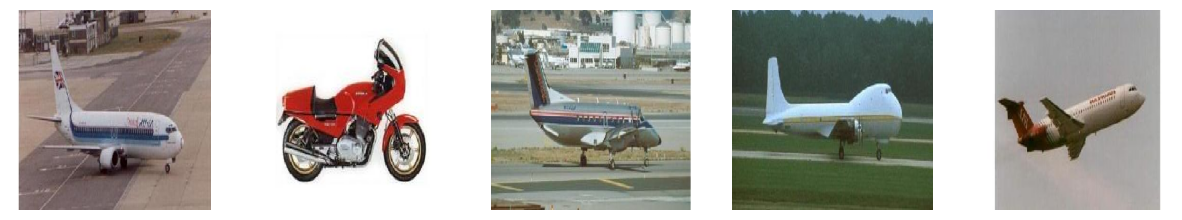

In [21]:
import matplotlib.pyplot as plt

def show_images(X, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        #Convert back from preprocessed form for visualization
        img = (X[i] + 1) / 2  #Scale  range
        plt.imshow(img)
        plt.axis('off')
    plt.show()

show_images(X_train)

###Requirements of the Xception Model:
- Image size: 299 x 299
- Expects RGB images (3 channels)
- Values should be in float32 format
- Scale pixel values to [-1,1]

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

##Building the model
We only require Xceptions' Feature Extractor to build our model for this use-case. We refrain from tweaking the Feature Extractor (the base model) and therefore we freezeits weights beforehand so that they are not updated during backpropogation

In [23]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
tf.random.set_seed(42)

#Xception model

Xception_model = keras.applications.Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="xception",
)

2.17.1
91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [24]:
Xception_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [26]:
base_model1 = keras.applications.xception.Xception(weights='imagenet', input_shape=(299, 299, 3),
                                                  include_top=False)

In [27]:
for layer in base_model1.layers:
  layer.trainabe = False

In [28]:
#classifier

from tensorflow.keras import layers


x = keras.layers.GlobalAveragePooling2D()(base_model1.output)
x = layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.25)(x)
output_ = layers.Dense(3, activation='softmax')(x)

model1 = keras.models.Model(inputs=[base_model1.input], outputs=[output_])

##Compile and train the model

In [29]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

model1.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

callbacks2 = [keras.callbacks.ModelCheckpoint("best_xception_TL.weights.h5",
                                              monitor='val_accuracy',
                                              save_weights_only=True,
                                              save_best_only=True)]

datagen = ImageDataGenerator(
    rotation_range=20,  #randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  #randomly shift images horizontally by up to 20%
    height_shift_range=0.2,  #randomly shift images vertically by up to 20%
    horizontal_flip=True,  #randomly flip images horizontally
    fill_mode='nearest',  #strategy for filling in newly created pixels
    validation_split=0.1 #10% validation split defined here
)

#Create train generator
train_generator = datagen.flow(
    X_train_std,
    y_train,
    batch_size=32,
    subset='training'    #Specify this is for training
)

#Create validation generator
validation_generator = datagen.flow(
    X_train_std,
    y_train,
    batch_size=32,
    subset='validation'  #Specify this is for validation
)

#Train the model
history = model1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=callbacks2
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.8763 - loss: 0.3704 - val_accuracy: 0.9758 - val_loss: 0.2001
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 956ms/step - accuracy: 0.9710 - loss: 0.0933 - val_accuracy: 0.8790 - val_loss: 0.3909
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9547 - loss: 0.0851 - val_accuracy: 0.9919 - val_loss: 0.1319
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 990ms/step - accuracy: 0.9979 - loss: 0.0098 - val_accuracy: 1.0000 - val_loss: 0.1227
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 958ms/step - accuracy: 0.9911 - loss: 0.0310 - val_accuracy: 0.9758 - val_loss: 0.1081
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 963ms/step - accuracy: 0.9967 - loss: 0.0134 - val_accuracy: 0.9758 - val_loss: 0.1507
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 960ms/step - accuracy: 0.9964 - loss: 0.0102 - val_accuracy: 0.9597 - val_loss: 0.1446
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 961ms/step - accuracy: 0.9952 - loss: 0.0122 - val_accuracy: 0.9839 - v

##Accuracy Plot

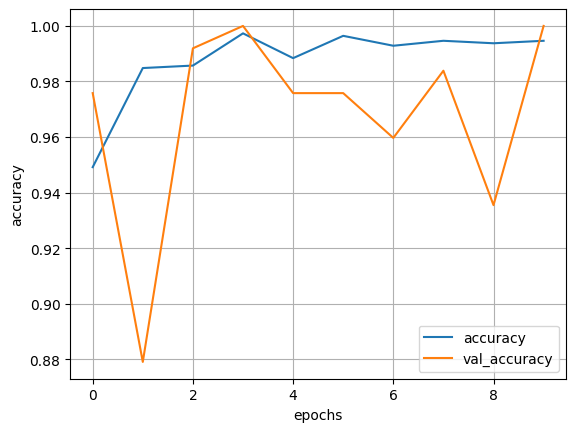

In [30]:
keys = ['accuracy', 'val_accuracy']
progress = {k:v for k,v in history.history.items() if k in keys}

import pandas as pd
pd.DataFrame(progress).plot()

plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.grid(True)
plt.show()

##Evaluate

In [31]:
testLoss1, testAccuracy1 = model1.evaluate(x = X_test_std, y = y_test)
print("Test-loss: %f, Test-accuracy: %f" % (testLoss1, testAccuracy1))

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.9959 - loss: 0.0190
Test-loss: 0.031021, Test-accuracy: 0.992788


##Update the model with the best weights

In [32]:
model1.load_weights("best_xception_TL.weights.h5")

testLoss1, testAccuracy1 = model1.evaluate(x = X_test_std, y = y_test)

print("Test-loss: %f, Test-accuracy: %f" % (testLoss1, testAccuracy1))

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.9971 - loss: 0.1240
Test-loss: 0.124476, Test-accuracy: 0.992788


#Performance

In [33]:
y_prob = model1.predict(X_test_std)
y_predict = np.argmax(y_prob, axis=-1)
print(y_predict)

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step
[1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1
 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0
 0 1 1 0 1 0 1 0 2 1 0 1 0 0 0 0 1 1 1 0 0 2 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0
 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 2 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1
 1 0 1 0 1 1 1 1 0 2 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1
 1 0 1 0 0 1 1 0 1 1 0 1 0 2 0 0 0 1 2 1 1 0 0 0 1 0 0 0 1 2 0 0 1 0 0 0 1
 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1
 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 2 2 1 1 1 1 0
 0 2 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1 0 2 1 2 0 0 0 0 1 0 1 0 0 0 1 1 2
 1 0 1 1 1 1 0 0 1 0 1 2 0 2 0 1 1 0 0 0 0 1 2 0 0 0 1 0 1 1 0 1 1 1 1 1 1
 0 0 1 1 0 0 1 0 1 2 1 0 0 0 0 0 1 1 0 1 1 0 2 1 1 1 1 1 1 1 0 1 0 1 1 0 1
 0 1 0 2 1 0 1 0 0]


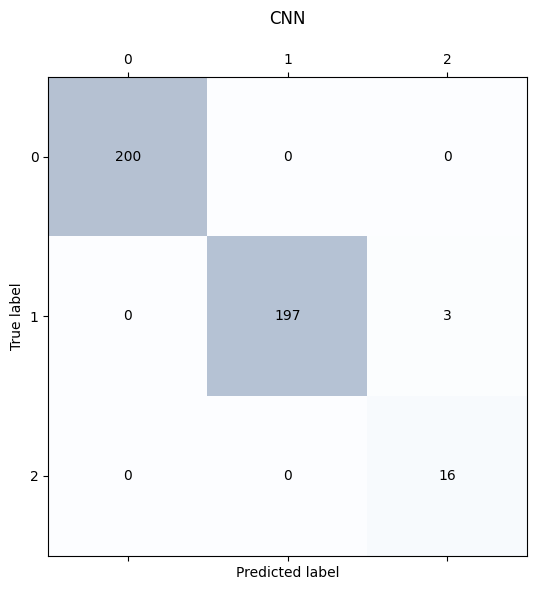

{0, 1, 2}
['Motorbikes' 'airplanes' 'schooner']


In [34]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true = y_test, y_pred = y_predict)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

ax.title.set_text('CNN\n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig("ConfusionMatrixXception.png", dpi=300, format='png', pad_inches=0.3)
plt.show()

print(set(y))
print(lEncoder.classes_)

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

pScore = precision_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("F1-score: ", fScore)


Precision:  0.9939271255060729
Recall:  0.9927884615384616
F1-score:  0.9930702798460984


##Save the model and datasets

In [36]:
model1.save('/content/gdrive/MyDrive/DL/Xception_Best_Model_TL.h5')

In [37]:
from numpy import save

save('/content/gdrive/MyDrive/DL/X_train_std.npy', X_train_std)
save('/content/gdrive/MyDrive/DL/X_test_std.npy', X_test_std)

save('/content/gdrive/MyDrive/DL/y_train.npy', y_train)
save('/content/gdrive/MyDrive/DL/y_test.npy', y_test)
